<center><h1>Combinaison d'algorithmes pour modéliser une prime</h1></center>

Vous trouverez ci-dessous un notebook proposant une première modélisation d'une prime d'une garantie auto
</br>Chaque ligne correspond à une exposition annuelle au risque
</br>Parmi les variables à expliquer :
<lu>
    <li>CHARGE => charge de sinistralité annuelle</li>
    <li>NB => Nombre de sinistres sur la période de l'année couverte</li>
    <li>EXPO => la durée annuelle d'exposition au risque</li>
    <li>FREQ => NB/EXPO</li>
    <li>COUT_MOYEN => COUT/NB</li>
</lu>
Les autres variables sont les variables explicatives avec pour toute variable X_PREC = 1 s'il y a eu un sinistre sur la garantie X par le passé

Votre objectif est de faire évoluer l'ensemble du notebook pour optimiser deux métriques sur la base de test :
<lu>
    <li><b>Métrique 1</b> : Minimisation de l'erreur quadratique moyenne de la prime </li>
    <li><b>Métrique 2</b> : Convergence du ratio Sinistres/Primes vers 1</li>
</lu>

La proposition ci-dessous ne tient pas compte de la variable EXPO, libre à vous de l'intégrer ou non aux travaux.
</br>Le fait de ne pas considérer la variable EXPO ne sera pas évalué et ne sera donc pas pénalisant

Vous pouvez opter pour l'une des stratégies suivantes :
<lu>
    <li><b>Stratégie 1</b> : Modélisation FREQ * COUT_MOYEN </li>
    <li><b>Stratégie 2</b> : Modélisation PROBA_SINISTRE * COUT où la variable COUT = CHARGE > 0</li>
    <li><b>Stratégie 3</b> : Modélisation directement de la charge</li>
</lu>

## ATTENTION Certains blocs de code ci-dessous ne doivent pas être modifiés
Via le libellé "Ne pas changer le bloc ci-dessous", il vous faudra juste comprendre et exécuter le bloc qui suit.
</br>A la lecture de ces blocs, vous comprendrez qu'il s'agira de benchmarker votre modélisation

## VOTRE RENDU

Merci de respecter les consignes suivantes :<lu>
    <li><b>Ce notebook complété</b> : des codes, des commentaires et des résultats obtenus</li>
    <li><b>Un page A4 au format PDF</b> : recensant l'ensemble des modèles testés et résultats obtenus ainsi que les next steps à envisager</li>
</lu>
</br>De manière facultative :
<lu>
    <li><b>Un 2nd notebook</b> : si vous hésitez entre deux modèles lors de l'analyse de vos résultats</li>
    <li><b>Tout reporting</b> : se reportant à la préparation de la donnée ou autre</li>
</lu>

In [1]:
%load_ext autoreload
%autoreload 2

In [222]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns

import plotly.express as px

from ModelMonitoring import ModelMonitoring

from visualisation import (
    plot_classification_metrics,
    plot_law_density,
    plot_law_qq,
    plot_metric_table,
    plot_scatter,
    qq_plot,
    plot_scatter,
    plot_fold_loss,
    plot_regression_diagnostics
)


In [3]:
bdd = pd.read_csv('./db_auto_dm_2025.csv',sep=";")
bdd.info(verbose=True, show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39944 entries, 0 to 39943
Data columns (total 29 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Unnamed: 0         39944 non-null  int64  
 1   CHARGE             39944 non-null  float64
 2   NB                 39944 non-null  int64  
 3   EXPO               39944 non-null  float64
 4   FREQ               39944 non-null  float64
 5   COUT_MOYEN         39944 non-null  float64
 6   ANNEE_EXPO         39944 non-null  int64  
 7   ANNEE_VEHICULE     39944 non-null  int64  
 8   ZONE_RISQUE        39944 non-null  object 
 9   AGE_ASSURE         39944 non-null  object 
 10  ANCIENNETE_PERMIS  39944 non-null  object 
 11  ANCIENNETE_ASSURE  39944 non-null  object 
 12  GENRE_ASSURE       39944 non-null  object 
 13  NB_KM              39944 non-null  object 
 14  SECOND_CONDUCTEUR  15508 non-null  object 
 15  FORMULE            39944 non-null  object 
 16  MODALITE_PAIEMENT  399

In [5]:
bdd2 = bdd.iloc[:,1:].copy()

In [10]:
px.histogram(bdd2.loc[bdd2['CHARGE']>0, 'CHARGE'],nbins=200)

Ratio du nombre de contrats, avec une 'charge' > 20k :

In [8]:
bdd2.loc[bdd2.CHARGE > 20000,'CHARGE'].count()/bdd2['CHARGE'].count()

0.0008011215701982776

Part de representation de ces outliers dans la somme des charges :

In [9]:
bdd2.loc[bdd2.CHARGE > 20000,'CHARGE'].sum()/bdd2['CHARGE'].sum()

0.15731558738414747

In [8]:
bdd2.loc[bdd2.CHARGE > 20000,'CHARGE'].sum()/bdd2['EXPO'].sum()

29.08763241187885

In [9]:
bdd2.loc[bdd2.CHARGE <= 20000,'CHARGE'].sum()/bdd2['EXPO'].sum()

155.8122423910549

## Ne pas changer le bloc ci-dessous - Préparation des données

In [6]:
# Ne pas modifier
bdd3 = bdd2.loc[bdd2.CHARGE < 20000]
features = bdd3.drop(columns=['CHARGE','NB','EXPO','COUT_MOYEN','FREQ'])
couts = np.asarray(bdd3['CHARGE'])
y = couts.copy()
y[y>0] = 1
expos = bdd3[['EXPO']]

## Analyse descriptives et data engineering

In [219]:
#from ydata_profiling import ProfileReport

#profile = ProfileReport(bdd3, title="prime-auto.html")

#profile.to_file(output_file='rapport-prime-auto.html')

In [7]:
def summarize_categoricals(df: pd.DataFrame) -> pd.DataFrame:
    def top3_distrib(series: pd.Series) -> list[str | None]:
        value_counts = series.value_counts(normalize=True)
        top3 = value_counts.head(3)
        return [f"{idx} ({round(pct*100,2)}%)" for idx, pct in top3.items()] + [None]*(3-len(top3))

    data = [[
        df[c].unique(),
        len(df[c].unique()),
        df[c].isnull().sum(),
        np.round((df[c].isnull().sum() / df.shape[0]) * 100, 1),
        df.dtypes[c],
        *top3_distrib(df[c])
    ] for c in df.columns]
    df_temp = pd.DataFrame(data, index=df.columns,
                        columns=['Levels', 'No. of Levels', 'No. of Missing Values', '% empty', 'type',
                                 'Top1', 'Top2', 'Top3'])
    return df_temp

summarize_categoricals(bdd3.round(2))

Levels  \
CHARGE             [4121.41, 0.0, 2500.0, 5697.29, 105.3, 111.15,...   
NB                                                         [1, 0, 2]   
EXPO               [1.0, 0.24, 0.86, 0.42, 0.99, 0.98, 0.06, 0.83...   
FREQ               [1.0, 0.0, 3.3, 8.49, 1.34, 1.23, 1.11, 2.87, ...   
COUT_MOYEN         [4121.41, 0.0, 2500.0, 2848.64, 105.3, 111.15,...   
ANNEE_EXPO                      [2021, 2022, 2024, 2023, 2020, 2019]   
ANNEE_VEHICULE     [2019, 2020, 2018, 2016, 2013, 2017, 2022, 201...   
ZONE_RISQUE                              [D, B, C, E, A, G, J, K, H]   
AGE_ASSURE         [(45,55], (55,65], (40,45], (65,75], (35,40], ...   
ANCIENNETE_PERMIS  [(25,60], (12,25], (8,12], (4,6], (6,8], (2,4]...   
ANCIENNETE_ASSURE              [(1,2], (-1,0], (0,1], (2,5], (5,10]]   
GENRE_ASSURE                                                  [M, F]   
NB_KM              [(5k,15k], (15k,30k], (30k,40k], (40k,60k], (5...   
SECOND_CONDUCTEUR                                    [NON, nan, OUI]   
FORMULE                                         [L1, L3, L4, L2, L5]   
MODALITE_PAIEMENT                     [MENSUEL, TRIMESTRIEL, ANNUEL]   
AGE_VEHICULE_      [(1,2], (-1,0], (0,1], (3,4], (2,3], (5,6], (4...   
ENERGIE_                                    [DIESEL, ESSENCE, AUTRE]   
NIVEAU_ANTIVOL                                       [1, 2, 3, 4, 5]   
PUISSANCE          [(110,130], (130,700], (95,110], (80,85], (90,...   
VALEUR_VEHICULE    [(35k,80k], (22k,25k], (25k,35k], (16k,18k], (...   
LEASING                                                   [NON, OUI]   
POIDS_PUISSANCE    [(17,18], (15,16], (13,15], (10,13], (0,10], (...   
RC_PREC_AN1                                               [0.0, 1.0]   
RC_PREC_AN2                                               [0.0, 1.0]   
DM_PREC                                                   [0.0, 1.0]   
BIV_PREC                                                  [0.0, 1.0]   
ZONE_GEO           [62, 84, 85, 58, 48, 54, 26, 10, 56, 35, 71, 2...   

                   No. of Levels  No. of Missing Values  % empty     type  \
CHARGE                      1582                      0      0.0  float64   
NB                             3                      0      0.0    int64   
EXPO                         101                      0      0.0  float64   
FREQ                         244                      0      0.0  float64   
COUT_MOYEN                  1580                      0      0.0  float64   
ANNEE_EXPO                     6                      0      0.0    int64   
ANNEE_VEHICULE                19                      0      0.0    int64   
ZONE_RISQUE                    9                      0      0.0   object   
AGE_ASSURE                     7                      0      0.0   object   
ANCIENNETE_PERMIS              8                      0      0.0   object   
ANCIENNETE_ASSURE              5                      0      0.0   object   
GENRE_ASSURE                   2                      0      0.0   object   
NB_KM                          7                      0      0.0   object   
SECOND_CONDUCTEUR              3                  24413     61.2   object   
FORMULE                        5                      0      0.0   object   
MODALITE_PAIEMENT              3                      0      0.0   object   
AGE_VEHICULE_                 10                      0      0.0   object   
ENERGIE_                       3                      0      0.0   object   
NIVEAU_ANTIVOL                 5                      0      0.0    int64   
PUISSANCE                     10                      0      0.0   object   
VALEUR_VEHICULE               10                      0      0.0   object   
LEASING                        2                      0      0.0   object   
POIDS_PUISSANCE                9                      0      0.0   object   
RC_PREC_AN1                    2                      0      0.0  float64   
RC_PREC_AN2                    2                

## zoom sur les changements structurels du dataset

### Données manquantes :
-> impute by ["missing"] strategy
- SECOND_CONDUCTEUR : 24413 missing values (61.2%)  


### Mauvais types :

interpreation en classes

- ZONE_GEO : int -> to object
- ANNEE_EXPO : int -> to object
- ANNEE_VEHICULE : int -> to object

valiarbles 0 ou 1

- RC_PREC_AN1 :  int -> to object,
- RC_PREC_AN2 :  int -> to object,
- DM_PREC :  int -> to object,
- BIV_PREC :  int -> to object


### Variables déséquilibrées : 
-> Choisir un KFOLD **stratifié**
- NB is highly imbalanced (80.2%)	
- ANCIENNETE_PERMIS is highly imbalanced (65.3%)	
- FORMULE is highly imbalanced (98.4%)	
- NIVEAU_ANTIVOL is highly imbalanced (59.3%)	
- LEASING is highly imbalanced (72.9%)	
- RC_PREC_AN1 is highly imbalanced (80.9%)	
- RC_PREC_AN2 is highly imbalanced (87.3%)	
- DM_PREC is highly imbalanced (92.6%)	
- BIV_PREC is highly imbalanced (93.4%)
  


### warnings, valeurs nulles :
- CHARGE has 37783 zeros(94.7%) 	
- FREQ has 37783 zeros (94.7%)	
- COUT_MOYEN has 37783 zeros (94.7%)


On change ici le type des années et zones géo, en variables catégorielles, cela va nous permettre de considérer chaques modalitées séparément et de leur calculer un coeficient unique à chaques valeurs.

- pour les zones géo, car on veux que chaques régions aient son propre coeficient.
- pour l'année d'exposition, même chose, on souahite que le modèle détermine lui même le coeficient  (si une année exposée est plus favorable aux primes par exemple)
- pour l'année du véhicule, on cherche aussi à calculer les coeficient de chaques années... mais on introduit un biais : l'âge du véhicule. En effet un 2019 peut représenter un véhicul neuf pour une expo en 2019, et 4 ans pour un vehicule ancien.
  - -> on modifie donc cette variable par $ \text{Age\_vehicule} = \text{Anne\_expo} - \text{Anne\_vehicule}  $



In [8]:
bdd4 = bdd3.copy()

# Créer AGE_VEHICULE en castant explicitement en int
#bdd4["AGE_VEHICULE"] = bdd4["ANNEE_EXPO"].astype("int") - bdd4["ANNEE_VEHICULE"].astype("int")

# Convertir les colonnes en string

for col in ["ZONE_GEO", "ANNEE_EXPO"]:
    bdd4[col] = bdd4[col].astype("object")

for col in ["RC_PREC_AN1", "RC_PREC_AN2", "DM_PREC", "BIV_PREC"]:
    bdd4[col] = bdd4[col].astype("object")

# Supprimer ANNEE_VEHICULE
#bdd4 = bdd4.drop(columns="ANNEE_VEHICULE")

## Annalyse des correlations

### Quantilisation (binning)

Nous allons utiliser un diagramme de correlation de pearson (similair au v de cramer)

Pour ce faire nous avons besoin de quantiliser nos variables quantitatives (ici déciles)

In [14]:
def num_to_cat(df_:pd.DataFrame, q=10, ignore_int=True, verbose=False)->pd.DataFrame:
    """ Convertit les variables numériques en déciles (catégorielles)"""
    df = df_.copy()
    for column in df.select_dtypes(include=['float64' if ignore_int else 'number']).columns:
        col = df[column]
        # découpe en 9 déciles en excluant les 0
        deciles, bins = pd.qcut(col.loc[col != 0], q=q-1, labels=False, retbins=True, duplicates='drop', precision=8)
        bins = [round(float(x), 2) for x in bins]
        # imperatif d'afficher les bins pour debug
        print(f"Converting {column} , déciles utilisés: {bins}")
        # inclure 0 dans le premier décile
        deciles = deciles +1
        bins = [0] + bins
        # créer une série avec les mêmes index que col, initialisée à "0"
        result = pd.Series("[0]", index=col.index)
        # créer les labels des déciles
        decile_labels = [f"({round(bins[i],1)},{round(bins[i+1],1)}]" for i in range(len(bins)-1)]
        # affecter noms de déciles aux individus
        result.loc[col != 0] = deciles.map(lambda d: decile_labels[int(d)] if pd.notnull(d) else d).values
        if verbose:
            print(result.value_counts())
        df[column] = result

    if ignore_int:
        for col in df.select_dtypes(include=['int']).columns:
            print(f"Converting {col} (int) directly to object")
            df[col] = df[col].astype('object')
    return df

Au vu des données, seules les variables continues seront quantilisées.
Les variables déjà en int ne présentes déja que trop peu de niveau (<10) il est donc innutile de les traiter et de perdre de l'information.

In [16]:
categorical_df = num_to_cat(bdd4,q=20, ignore_int=True)

Converting CHARGE , déciles utilisés: [0.81, 109.98, 117.0, 279.46, 491.7, 672.19, 829.43, 1009.49, 1199.56, 1382.31, 1602.17, 1834.41, 2142.78, 2500.0, 2610.22, 3124.1, 3801.89, 4889.37, 7609.06, 19449.3]
Converting EXPO , déciles utilisés: [0.0, 0.15, 0.29, 0.43, 0.54, 0.64, 0.74, 0.83, 0.83, 0.88, 1.0, 1.0, 1.0]
Converting FREQ , déciles utilisés: [1.0, 1.0, 1.0, 1.02, 1.16, 1.2, 1.38, 1.57, 1.94, 2.17, 3.21, 243.33]
Converting COUT_MOYEN , déciles utilisés: [0.81, 109.98, 117.0, 276.28, 479.57, 663.88, 819.97, 982.59, 1155.4, 1338.28, 1551.91, 1773.11, 2012.27, 2421.1, 2500.0, 2905.88, 3514.47, 4623.81, 7367.07, 19449.3]
Converting NB (int) directly to object
Converting ANNEE_VEHICULE (int) directly to object
Converting NIVEAU_ANTIVOL (int) directly to object


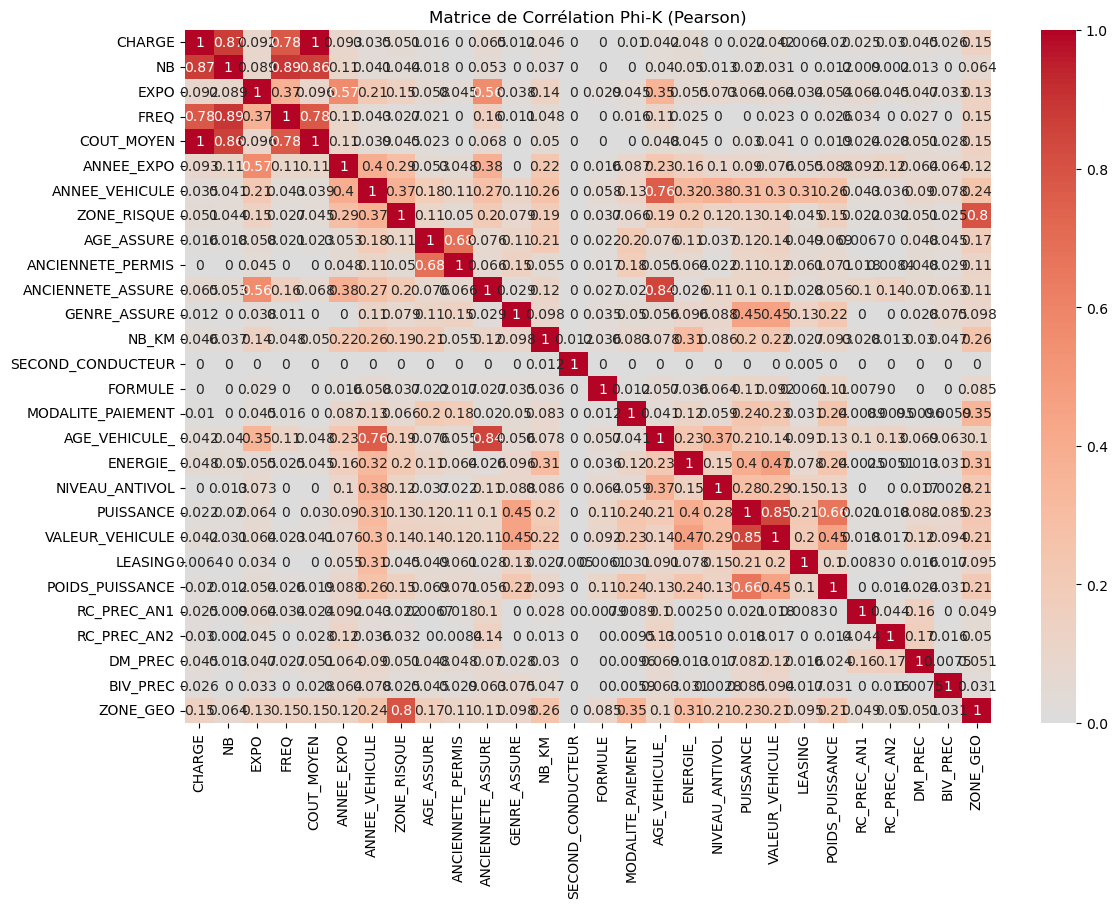

In [ ]:

from phik import phik_matrix

corr_matrix = phik_matrix(categorical_df)

plt.figure(figsize=(13, 9))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", center=0)
plt.title("Matrice de Corrélation Phi-K (Pearson)")
plt.show()


## Choisir à votre convenance le format de chaque colonne

In [9]:
# a été réécrit

# Séparer les colonnes numériques et catégorielles
variables_num = features.select_dtypes(exclude="object").columns
variables_cat = features.select_dtypes(include="object").columns

# Récupérer les indices
numeric_indices = [i for i, col in enumerate(features.columns) if col in variables_num]
categorical_indices = [i for i, col in enumerate(features.columns) if col in variables_cat]

categorical_indices, numeric_indices

([2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 14, 15, 16, 17],
 [0, 1, 13, 18, 19, 20, 21, 22])

## Ne pas changer le bloc ci-dessous - Split des données en base de test et bases de validation

In [10]:
# Ne pas modifier
from sklearn.model_selection import train_test_split, KFold

X = features.copy()
X_train, X_test, couts_train, couts_test, y_train, y_test = train_test_split(X, couts, y, test_size=0.2, random_state=3)

kf = KFold(n_splits=4, shuffle=True, random_state=2)
les_splits = []

for train_index, valid_index in kf.split(X_train):
    les_splits.append([train_index, valid_index])

les_splits

[[array([    1,     3,     4, ..., 31925, 31926, 31928]),
  array([    0,     2,     6, ..., 31917, 31923, 31927])],
 [array([    0,     2,     3, ..., 31926, 31927, 31928]),
  array([    1,     4,     5, ..., 31918, 31919, 31921])],
 [array([    0,     1,     2, ..., 31923, 31925, 31927]),
  array([    3,     7,    14, ..., 31924, 31926, 31928])],
 [array([    0,     1,     2, ..., 31926, 31927, 31928]),
  array([    9,    12,    13, ..., 31912, 31922, 31925])]]

## Préprocessing - A vous de jouer 

In [11]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, FunctionTransformer
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer

# Créer un ColumnTransformer pour l'imputation et le prétraitement des variables
preprocessor = ColumnTransformer(
    transformers=[
        ('num', Pipeline([
            ('imputer', SimpleImputer(strategy='median')),
            ('scaler', StandardScaler())
        ]), numeric_indices),
        ('cat', Pipeline([
            ('imputer', SimpleImputer(strategy='most_frequent', fill_value='missing')),
            ('encoder', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
        ]), categorical_indices)
    ])


# Analyse du modèle linéaire

## Mise en route du modèle linéaire généralisé
Etant donné que l'utilisation de modèles linéaires dans le secteur financier est très important. Donnons une analyse plus poussée de celui-ci.

On s'assure d'une loi qui resprésnte les données.

## Ajustement à une loi, KS-bootstrap

Le test de Kolmogorov–Smirnov nous donne une statistique qui mesure l'équart entre deux distributions.

1. On pose un test d'hypothese : $ H_0 \text{vs}  H_1$
2. On part d'une loi connue,  où on ajuste ses paramètres $\theta$ (par Maximum de vraissemblance)
2. On compare la statistique D, on rejete ou non statistiqueemnt l'hypothese

Problème : en pratique, on estime $\theta$ à partir des données (ex. via Maximum de Vraisemblance).
Résultat : la distribution nulle du test de base n’est plus la loi KS standard (Kolmogorov distribution).
 - -> Le test devient trop « sévère » où les p-values ≈ 0 même si le modèle est bon
  
L'idée est donc de faire du **bootstrap parametrique** pour contourner ce biais

1. On calcule la satistique de test classique
2. On simule plein de jeux de données depuis la loi ajustée aux données (par MLE)
3. Pour chaque jeu simulé, on ré-estime les paramètres
4. On calcule la statistique KS pour chaque jeu simulé
5. Calculer la p-value bootstrap (de l'ensemble des tests simulés)

## Modélisation avec la loie Gamma

- ->Nous prendrons la loi Gamma, connue en actuariat pour modéliser les coûts.



In [184]:
from scipy import stats 

In [ ]:
data = couts[couts > 0]

In [ ]:
def bootstrap_kstest(data, dist, n_boot=1000, random_state=None):
    rng = np.random.default_rng(random_state)
    data = np.asarray(data)
    n = data.size

    # 1) fit la distribution aux données (MLE)
    fitted_params = dist.fit(data) 
    # statistique de test (classical)
    ks_obs, p_classical = stats.kstest(data, dist.name, args=fitted_params)

    # 2) bootstrap
    ks_boot = np.empty(n_boot)
    for i in range(n_boot):
        # simuler de nouveaux échantillons à partir de la distribution ajustée
        sim = dist.rvs(*fitted_params, size=n, random_state=rng)
        # re-fit parametres sur les echantillons simulés
        params_sim = dist.fit(sim)
        # calculer la statistique KS pour l'échantillon simulé par rapport à sa CDF ajustée
        ks_boot[i] = stats.kstest(sim, dist.name, args=params_sim)[0]

    # bootstrap p-value: proportion de bootstrap KS >= KS observé
    p_boot = (np.sum(ks_boot >= ks_obs) + 1) / (n_boot + 1)

    print("fit params:", fitted_params)
    print("Statistique de test (KS obs) =", ks_obs)
    print("p-value classique =", p_classical)
    print("p-value bootstrap =", p_boot)
    print("nombre d'échantillons bootstrap >= ks_obs =", np.sum(ks_boot >= ks_obs), "sur 1000")
    
    return {"ks_obs": ks_obs, "p_classical": p_classical, "p_bootstrap": p_boot,
            "fitted_params": fitted_params, "nb_ks_boot": np.sum(ks_boot >= ks_obs)}
    

**Hypothèse du test de Kolmogorov-Smirnov :**
- $H_0$ : Le coût d'un sinistre suit une loi Gamma.
- $H_1$ : Le coût dun sinistre ne suit pas une loi Gamma.

In [230]:
res_gamma = bootstrap_kstest(data, stats.gamma, n_boot=1000, random_state=123)

Gamma fit params: (0.9076565691808591, -0.14547432636607982, 2465.9100308348907)
Statistique de test (KS obs) = 0.06619198040742565
p-value classique = 1.4880660365412044e-08
p-value bootstrap = 0.26873126873126874
nombre d'échantillons bootstrap >= ks_obs = 268 sur 1000


**Hypothèse du test de Kolmogorov-Smirnov :**
- $H_0$ : Le coût d'un sinistre suit une loi Gamma.
- $H_1$ : Le coût dun sinistre ne suit pas une loi Gamma.

In [241]:
res_lognorm = bootstrap_kstest(data, stats.lognorm, n_boot=1000, random_state=123)

/opt/anaconda3/lib/python3.12/site-packages/scipy/stats/_continuous_distns.py:6545: RuntimeWarning:

invalid value encountered in log



Gamma fit params: (1.1451131214578123, -65.29514652052742, 1330.9763518012803)
Statistique de test (KS obs) = 0.08927494467287353
p-value classique = 3.251538516830361e-15
p-value bootstrap = 0.000999000999000999
nombre d'échantillons bootstrap >= ks_obs = 0 sur 1000


| Distribution | KS Observed | p-value (bootstrap) |
|--------------|-------------|---------------------|
| Gamma        | 0.0662      | 0.269               |
| Log-Normal   | 0.0893      | 0.001               |

Ces résultats révèlent qu’au seuil de 5%, on ne peut rejeter l’hypothèse nulle selon laquelle le coût d'un sinistre est distribué selon une loi Gamma.

Cependant, ces derniers suggèrent qu’on peut fortement rejeter l’hypothèse selon laquelle elle distribué selon une loi Log-normale.

Les analyses graphiques et numériques suivantes permettent d’évaluer le niveau d’adéquation qui pourrait exister entre la distribution des coûts et la loi Gamma.

In [248]:
fitted_params_gamma = res_gamma["fitted_params"]
gamma_theoretical = stats.gamma(*fitted_params_gamma)
plot_law_density(data, gamma_theoretical, "Gamma")

In [249]:
plot_law_qq(data, gamma_theoretical, "Gamma")

L'analyse graphique nous montre bien une concordance entre la loi gamma et la densitée empirique des nos couts.

## Apprentissage supervisé tant pour la classification que la régression - A vous de jouer

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import GammaRegressor

# Créer un pipeline avec prétraitement et modèle
pipeline_LogReg = Pipeline([
    ('preprocessor', preprocessor),
    ('model', LogisticRegression(class_weight = {0:1,1:9}))
])

# Créer un pipeline avec prétraitement et modèle
pipeline_GammaReg = Pipeline([
    ('preprocessor', preprocessor),
    ('model', GammaRegressor(alpha=0.85))
])


In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor

# Define parameter grid for RandomizedSearchCV
param_grid_LogReg = {
    'model__C': [0.1, 0.5, 1],
    'model__penalty': ['l1'],
    'model__solver': ['liblinear'],
    'model__class_weight': [{0:1, 1:9}],
    
}
param_dist_RF = {
    'model__max_depth': [30],
    'model__min_samples_split': [2],  # 5, 10],
    'model__min_samples_leaf': [1]  # , 2, 4],
}

# Create pipeline
pipeline_LogReg = Pipeline([
    ('preprocessor', preprocessor),
    ('model', LogisticRegression(max_iter=1000, random_state=42))
])

pipeline_RF = Pipeline([
    ('preprocessor', preprocessor),
    ('model', RandomForestRegressor(n_jobs=-1, n_estimators=100, random_state=42))
])

# Randomized search
grid_search_LogReg = GridSearchCV(
    pipeline_LogReg,
    param_grid=param_grid_LogReg,
    scoring=["neg_root_mean_squared_error","r2"],
    refit='neg_root_mean_squared_error',
    cv=3,
    verbose=1,
    n_jobs=-1
)

grid_search_RF = GridSearchCV(
    pipeline_RF,
    param_grid=param_dist_RF,
    scoring=['neg_root_mean_squared_error',"r2"],
    refit='neg_root_mean_squared_error',
    cv=[(slice(None), slice(None))],
    verbose=1,
    n_jobs=-1
)

# random_search = RandomizedSearchCV(
#     pipeline_LogReg,
#     param_distributions=param_dist_LogReg,
#     n_iter=3,
#     scoring='neg_root_mean_squared_error',
#     verbose=1,
#     n_jobs=-1,
#     random_state=42
# )



# entrainement de modeles (TODO)


## Modèles linéaires

### Modèle Log-normal (TODO)

In [65]:
grid_search_LogReg.fit(X_train, y_train)

Fitting 3 folds for each of 3 candidates, totalling 9 fits


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(strategy='median')),
                                                                                         ('scaler',
                                                                                          StandardScaler())]),
                                                                         [0, 1,
                                                                          13,
                                                                          18,
                                                                          19,
                                                                          20,
                                                                          21,
                                                                          22]),
                                                                        ('cat',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(fill_value='missing',
                                                                                                        strategy='most_frequent')),
                                                                                         ('encoder',
                                                                                          OneHotEncoder(handle_unknown='ignore'))]),
                                                                         [2, 3,
                                                                          4, 5,
                                                                          6, 7,
                                                                          8, 9,
                                                                          10,
                                                                          11,
                                                                          12,
                                                                          14,
                                                                          15,
                                                                          16,
                                                                          17])])),
                                       ('model',
                                        LogisticRegression(max_iter=1000,
                                                           random_state=42))]),
             n_jobs=-1,
             param_grid={'model__C': [0.1, 0.5, 1],
                         'model__class_weight': [{0: 1, 1: 9}],
                         'model__penalty': ['l1'],
                         'model__solver': ['liblinear']},
             refit='neg_root_mean_squared_error',
             scoring=['neg_root_mean_squared_error', 'r2'], verbose=1)

In [40]:
pd.DataFrame(grid_search_LogReg.cv_results_).sort_values(by="rank_test_r2").transpose()

0  \
mean_fit_time                                                                     5.034019   
std_fit_time                                                                           0.0   
mean_score_time                                                                   0.191186   
std_score_time                                                                         0.0   
param_model__C                                                                         0.1   
param_model__class_weight                                                             None   
param_model__penalty                                                                    l1   
param_model__solver                                                              liblinear   
params                                   {'model__C': 0.1, 'model__class_weight': None,...   
split0_test_neg_root_mean_squared_error                                          -0.230201   
mean_test_neg_root_mean_squared_error                                            -0.230201   
std_test_neg_root_mean_squared_error                                                   0.0   
rank_test_neg_root_mean_squared_error                                                    1   
split0_test_r2                                                                   -0.055958   
mean_test_r2                                                                     -0.055958   
std_test_r2                                                                            0.0   
rank_test_r2                                                                             1   

                                                                                         2  \
mean_fit_time                                                                     9.462441   
std_fit_time                                                                           0.0   
mean_score_time                                                                   0.172536   
std_score_time                                                                         0.0   
param_model__C                                                                         0.5   
param_model__class_weight                                                             None   
param_model__penalty                                                                    l1   
param_model__solver                                                              liblinear   
params                                   {'model__C': 0.5, 'model__class_weight': None,...   
split0_test_neg_root_mean_squared_error                                          -0.230201   
mean_test_neg_root_mean_squared_error                                            -0.230201   
std_test_neg_root_mean_squared_error                                                   0.0   
rank_test_neg_root_mean_squared_error                                                    1   
split0_test_r2                                                                   -0.055958   
mean_test_r2                                                                     -0.055958   
std_test_r2                                                                            0.0   
rank_test_r2                                                                             1   

                                                                                         4  \
mean_fit_time                                                                    11.892637   
std_fit_time                                                                           0.0   
mean_score_time                                                                   0.169289   
std_score_time                                                                         0.0   
param_model__C                                                                           1   
param_model__class_weight                                                             None   
param_model__penalty                         

In [68]:
y_pred = best_model_LogReg.predict(X_train)
y_pred.mean()

0.04544458016223496

### Modèle Gamma (TODO)

In [49]:
pipeline_GammaReg.fit(X_train[y_train>0], y_train[y_train>0])

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  [0, 1, 13, 18, 19, 20, 21,
                                                   22]),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(fill_value='missing',
                                                                                 strategy='most_frequent')),
                                                                  ('encoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  [2, 3, 4, 5, 6, 7, 8, 9, 10,
                                                   11, 12, 14, 15, 16, 17])])),
                ('model', GammaRegressor(alpha=0.85))])

## modèles ensemblistes

### Random forest (retenir?)

In [41]:
pipeline_RF.fit(X_train, couts_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  [0, 1, 13, 18, 19, 20, 21,
                                                   22]),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(fill_value='missing',
                                                                                 strategy='most_frequent')),
                                                                  ('encoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  [2, 3, 4, 5, 6, 7, 8, 9, 10,
                                                   11, 12, 14, 15, 16, 17])])),
                ('model', RandomForestRegressor(n_jobs=-1, random_state=42))])

In [ ]:
grid_search_RF.fit(X_train, y_train)

In [ ]:
pd.DataFrame(grid_search_RF.cv_results_).sort_values(by="rank_test_neg_root_mean_squared_error").transpose()

In [95]:
best_model_RF = grid_search_RF.best_estimator_

### XGBoost (TODO)

## Reseaux de neurones

### deepLearning (keras ou torch) (TODO)

# Benchmark (temporaire) de models

### de random forest (sans gridsearch)

In [43]:
y_pred = pipeline_RF.predict(X_train)
qqplot_plotly(couts_train, y_pred)

In [46]:
y_pred = pipeline_RF.predict(X_test)
qqplot_plotly(couts_test, y_pred)

In [60]:
y_pred = best_model_LogReg.predict(X_test)
y_pred.mean()

0.0

### Rapport de classification [Gamma Regression] : 
               precision    recall  f1-score   support

         0.0       0.95      0.96      0.95     30237
         1.0       0.11      0.10      0.11      1692

    accuracy                           0.91     31929
   macro avg       0.53      0.53      0.53     31929
weighted avg       0.91      0.91      0.91     31929



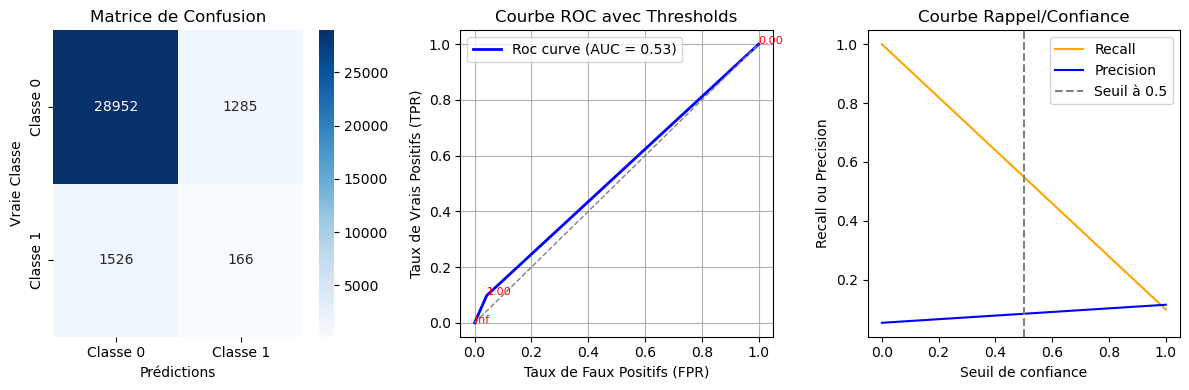

In [69]:
y_pred = best_model_LogReg.predict(X_train)
plot_classification_metrics("Gamma Regression", y_train, y_pred>0.5, y_pred)

Aucun pouvoir de prédiction : mauvais hyper parametres

# (TODO) Next step : intégrer les pipelines retenus dans l'entrainement multi models

In [59]:
import copy
import time
from sklearn.base import clone
import xgboost as xgb

def measure_time(func, *args, **kwargs):
    start = time.time()
    result = func(*args, **kwargs)
    elapsed = time.time() - start
    return result, elapsed

GammaRegMonitor = ModelMonitoring("Gamma Regression")

xgbMonitor = ModelMonitoring("XGBoost General Regression")

results = []
for train_index, valid_index in les_splits:
    
    train_x = X_train.iloc[train_index,:]
    train_y = y_train[train_index]
    train_c = couts_train[train_index]
    valid_x = X_train.iloc[valid_index,:]
    valid_y = y_train[valid_index]
    valid_c = couts_train[valid_index]

    #Trouvez le pipeline optimal pour la probabilité de sinistre
    _, time_LogReg = measure_time(pipeline_LogReg.fit, train_x, train_y) 
    preds_LogReg = pipeline_LogReg.predict(valid_x)

    #Trouvez le pipeline optimal pour le coût d'un sinistre
    _ , time_GammaReg = measure_time(pipeline_GammaReg.fit, train_x[train_y>0], train_c[train_y>0]) 
    preds_GammaReg = pipeline_GammaReg.predict(valid_x)
    
    ######### model xgboost ########
    # xgbModel = xgb.XGBRegressor(
    #     objective ='reg:squarederror', booster ='gbtree', base_score=3,
    #     evals_result=xgb_evals_result, n_estimator=30, n_jobs=-1)
    # _, time_XGB = measure_time(xgbModel.fit, train_x[train_y>0], train_c[train_y>0], eval_set=[(valid_x[valid_y>0], valid_c[valid_y>0])])
    
    xgb_loss_result = {}
    dtrain = xgb.DMatrix(preprocessor.transform(train_x[train_y>0]), label=train_c[train_y>0])
    dvalid = xgb.DMatrix(preprocessor.transform(valid_x[valid_y>0]), label=valid_c[valid_y>0])

    params = {'objective':'reg:squarederror', 'booster':'gbtree', 'base_score':3}
    xgbModel, time_xgb = measure_time(
        xgb.train,
        params,
        dtrain,
        num_boost_round=100,
        # watchlist=[(dtrain, 'train'), (dvalid, 'eval')],
        evals=[(dtrain, 'train'), (dvalid, 'validation')],
        early_stopping_rounds=3,
        evals_result=xgb_loss_result,
        verbose_eval=False
    )
    preds_XGB = xgbModel.predict(dvalid)



    # Reconstitution de la base globale pour ce fold
    df_test = valid_x.copy()
    df_test = df_test.assign(
        couts=valid_c,
        y=(valid_c > 0).astype(int),
        pred_c=preds_GammaReg,
        pred_y=preds_LogReg,
        pred_prime=[max(5, x) for x in (preds_LogReg * preds_GammaReg)]
    )

    # Monitoring Gamma Regression
    GammaRegMonitor.log(
        y_true=valid_c,
        y_pred=preds_GammaReg,
        time=time_GammaReg,
        loss=None,
        model=clone(pipeline_GammaReg)
    )
    # Monitoring XGBoost
    xgbMonitor.log(
        y_true=valid_c[valid_y>0],
        y_pred=preds_XGB,
        time=time_xgb,
        loss=[xgb_loss_result['train']['rmse'], xgb_loss_result['validation']['rmse']],
        model=copy.deepcopy(xgbModel)
    )

    # Concaténation des folds
    results.append(df_test) 
    

/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



In [82]:
import plotly.graph_objs as go

def plot_aggregated_loss(train_data, eval_data, model_name):
    fig = go.Figure()
    fig.add_trace(go.Scatter(y=train_data, mode='lines', name='Train RMSE'))
    fig.add_trace(go.Scatter(y=eval_data, mode='lines', name='Valid RMSE'))
    fig.update_layout(
        title=f'Evolution de la loss : {model_name}',
        xaxis_title='Itération',
        yaxis_title='RMSE',
        legend_title='Dataset'
    )
    fig.show()
    return fig

def plot_fold_loss(fold_loss, model_name):
    # Utilise la palette plotly par défaut
    plotly_colors = [
        "#636EFA", "#EF553B", "#00CC96", "#AB63FA", "#FFA15A", "#19D3F3", "#FF6692", "#B6E880"
    ]
    fig = go.Figure()
    for i, (train_data, eval_data) in enumerate(fold_loss):
        color = plotly_colors[i % len(plotly_colors)]
        fig.add_trace(go.Scatter(
            y=train_data, mode='lines', name=f'Fold {i+1}: Train',
            line=dict(color=color, width=2)
        ))
        fig.add_trace(go.Scatter(
            y=eval_data, mode='lines', name=f'Fold {i+1}: Valid',
            line=dict(color=color, width=2, dash='dash'),
            opacity=0.7
        ))
    fig.update_layout(
        title=f'Evolution de la loss par fold : {model_name}',
        xaxis_title='Itération',
        yaxis_title='RMSE',
        legend_title='Dataset'
    )
    # fig.show()
    return fig

In [107]:
import seaborn as sns

import matplotlib.pyplot as plt

def plot_aggregated_loss(aggregated_loss, model_name):
    train_data, eval_data = aggregated_loss
    plt.figure(figsize=(6, 4))
    plt.plot(train_data, label='Mean Train RMSE')
    plt.plot(eval_data, label='Mean Valid RMSE')
    plt.title(f'Evolution moyenne des loss : {model_name}')
    plt.xlabel('Itération')
    plt.ylabel('RMSE')
    plt.legend()
    plt.show()

def plot_fold_loss(fold_loss, model_name):
    plt.figure(figsize=(6, 4))
    colors = sns.color_palette("tab10", n_colors=len(fold_loss))
    for i, (train_data, eval_data) in enumerate(fold_loss):
        plt.plot(train_data, label=f'Fold {i+1}: Train', color=colors[i])
        plt.plot(eval_data, label=f'Fold {i+1}: Valid', color=colors[i], linestyle='--', alpha=0.7)
    plt.title(f'Evolution de la loss par fold : {model_name}')
    plt.xlabel('Itération')
    plt.ylabel('RMSE')
    plt.legend()
    plt.show()


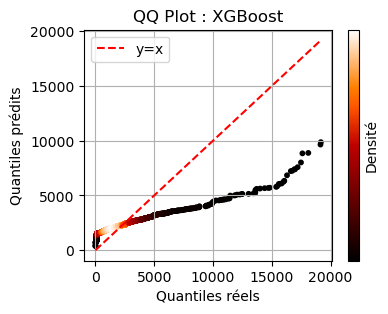

In [202]:
from scipy.stats import gaussian_kde

def qq_plot(y_true, y_pred, model_name):

    quantiles = np.linspace(0, 1, min(len(y_true), len(y_pred)))
    q_true = np.quantile(y_true, quantiles)
    q_pred = np.quantile(y_pred, quantiles)

    # Calculer la densité pour chaque point
    xy = np.vstack([q_true, q_pred])
    z = gaussian_kde(xy)(xy)

    plt.figure(figsize=(4, 3))
    sc = plt.scatter(q_true, q_pred, c=z, cmap='gist_heat', s=10) 
    max_val = max(q_true.max(), q_pred.max())
    plt.plot([0, max_val], [0, max_val], color='red', linestyle='--', label='y=x')
    plt.xlabel("Quantiles réels")
    plt.ylabel("Quantiles prédits")
    plt.title(f"QQ Plot : {model_name}")
    plt.legend()
    plt.grid(True)
    plt.colorbar(sc, label='Densité', ticks=[])
    plt.show()

qq_plot(xgbMonitor.aggregated_truth, xgbMonitor.aggregated_preds, "XGBoost")


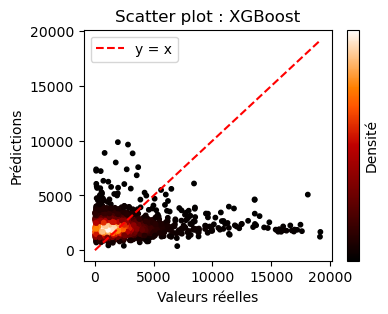

In [201]:
def plot_scatter(y_true, y_pred, model_name):
    # Calculer la densité pour chaque point
    xy = np.vstack([y_true, y_pred])
    z = gaussian_kde(xy)(xy)
    
    plt.figure(figsize=(4, 3))
    sc = plt.scatter(y_true, y_pred,  c=z, cmap='gist_heat', s=10)
    plt.xlabel("Valeurs réelles")
    plt.ylabel("Prédictions")
    plt.title(f"Scatter plot : {model_name}")
    plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'r--', label='y = x')
    plt.legend()
    plt.colorbar(sc, label='Densité', ticks=[])
    plt.show()

plot_scatter(xgbMonitor.aggregated_truth, xgbMonitor.aggregated_preds, "XGBoost")

In [ ]:
import statsmodels.api as sm
import pylab

sm.qqplot(test, line='45')
pylab.show()


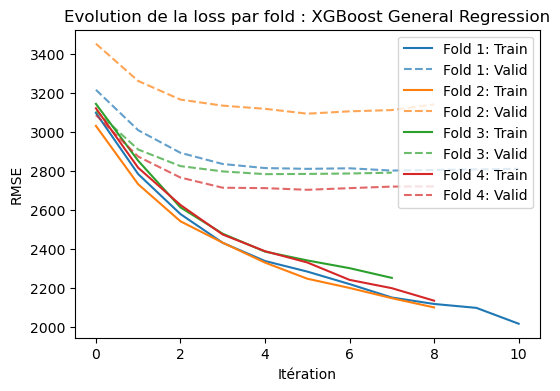

In [155]:
plot_fold_loss(xgbMonitor.fold_loss, "XGBoost General Regression")

In [ ]:
df_metrics


Fold 1   Fold 2   Fold 3   Fold 4  Moyenne  Ecart-type
r2      -0.07    -0.10    -0.10    -0.04    -0.08        0.03
mae   1806.03  1970.76  1830.83  1722.50  1832.53      103.15
rmse  2812.91  3143.33  2793.05  2722.63  2867.98      187.61
time     0.02     0.01     0.02     0.01     0.02        0.01

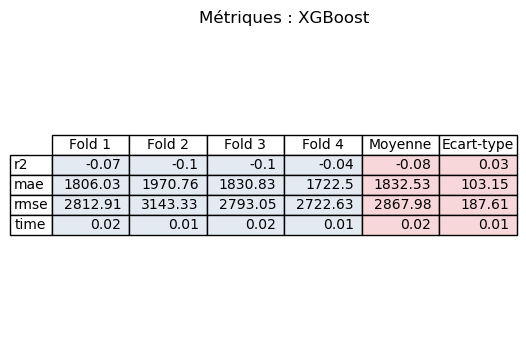

In [205]:
import numpy as np
import seaborn as sns

def plot_metric_table(fold_metrics, model_name):
    df_metrics = pd.DataFrame(fold_metrics).T
    df_metrics.columns = [f"Fold {i+1}" for i in range(df_metrics.shape[1])]
    df_metrics["Moyenne"] = df_metrics.mean(axis=1).round(2)
    df_metrics["Ecart-type"] = df_metrics.drop(columns=["Moyenne"]).std(axis=1).round(2)

    # Palette de couleurs : une couleur par colonne, rouge clair pour les deux dernières

    import matplotlib.pyplot as plt
    # Affichage stylisé avec matplotlib : gris pour les folds, rouge clair pour Moyenne et Ecart-type
    fig, ax = plt.subplots(figsize=(5, 4 ))
    # Définir les couleurs pour chaque colonne
    cell_colors = []
    for i in range(len(df_metrics)):
        row = []
        for j in range(df_metrics.shape[1]):
            if j >= df_metrics.shape[1] - 2:
                row.append('#f8d7da')  # rouge clair pour Moyenne et Ecart-type
            else:
                row.append('#e3eaf2')  # gris clair pour les folds
        cell_colors.append(row)

    # Afficher le tableau
    table = ax.table(
        cellText=np.round(df_metrics.values, 2),
        rowLabels=df_metrics.index,
        colLabels=df_metrics.columns,
        cellColours=cell_colors,
        loc='center'
    )
    table.auto_set_font_size(False)
    table.set_fontsize(10)
    table.scale(1.2, 1.2)
    ax.axis('off')
    plt.title(f"Métriques : {model_name}")
    plt.show()

plot_metric_table(xgbMonitor.fold_metrics, "XGBoost")

In [60]:
plot_loss(*xgbMonitor.aggregated_loss, "xGBoost General Regression")

In [19]:
xgbMonitor.aggregated_loss

array([[3099.55223733, 2785.68461526, 2580.65410648, 2433.23326922,
        2339.87306254, 2285.66776669, 2221.49929887, 2152.74317247,
        2119.60469171, 2099.53097513, 2018.25079813, 1954.15865332,
        1937.14232412, 1886.2752432 , 1869.71735692, 1773.33495077,
        1717.70302945, 1642.41784374, 1586.60648382, 1530.81654131,
        1506.8440145 , 1480.24883682, 1463.48991993, 1425.47996032,
        1397.99132738, 1371.84394543, 1368.41831066, 1332.81941277,
        1308.49460474, 1285.2878335 , 1262.2043914 , 1227.00577099,
        1196.79774466, 1180.92377667, 1175.78281357, 1151.56657176,
        1110.58846795, 1106.21695028, 1075.12650667, 1059.88161869,
        1052.63709119, 1051.54633313, 1042.71072007, 1017.68801161,
         975.85436817,  965.78000108,  957.22308757,  941.43323753,
         920.85293061,  909.78627318,  898.01664912,  888.22087976,
         867.77820901,  846.07109963,  830.32724185,  820.70488732,
         791.77444641,  773.31163935,  761.88439

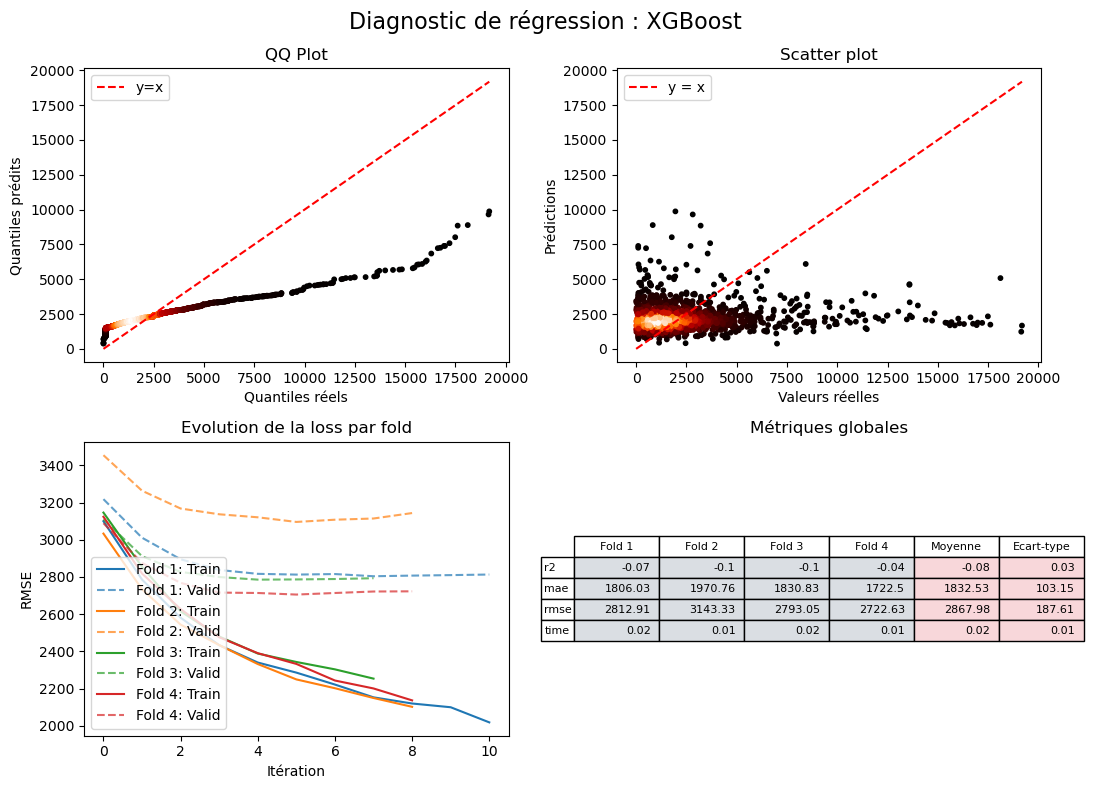

In [235]:
plot_regression_diagnostics(xgbMonitor.aggregated_truth, xgbMonitor.aggregated_preds, xgbMonitor.fold_loss, xgbMonitor.fold_metrics, model_name="XGBoost")

In [466]:
qqplot_plotly(xgbMonitor.aggregated_truth, xgbMonitor.aggregated_preds, title="XGBoost - QQ plot")

In [465]:
xgbMonitor.aggregated_metrics

{'r2_mean': -0.235,
 'mae_mean': 1974.775,
 'rmse_mean': 3068.735,
 'time_mean': 0.162,
 'r2_std': 0.017,
 'mae_std': 100.172,
 'rmse_std': 159.769,
 'time_std': 0.043}

In [274]:
GammaRegMonitor.aggregated_metrics

{'r2_mean': -7.132,
 'r2_std': 0.683,
 'mae_mean': 2267.028,
 'mae_std': 20.424,
 'rmse_mean': 2329.388,
 'rmse_std': 18.831,
 'time_mean': 0.065,
 'time_std': 0.01}

Concaténation des bases de validation enrichies

In [275]:
GammaRegMonitor.fold_preds

{0: array([2058.92139315, 2063.58761976, 2450.74976414, ..., 2412.68969707,
        2190.24010816, 2565.51621072]),
 1: array([2137.16790497, 2427.99673469, 2109.19741732, ..., 2260.26564339,
        2277.46489722, 2161.27120091]),
 2: array([2222.51949951, 2157.08160023, 2372.68601236, ..., 2418.32560286,
        2239.22975637, 2091.12192619]),
 3: array([2439.43270841, 2035.46506582, 2302.75226794, ..., 2123.52955834,
        2378.76497438, 2347.84221156])}

In [282]:
gamma_y_pred = np.concatenate(list(GammaRegMonitor.fold_preds.values()))

In [283]:
gamma_y_true = np.concatenate(list(GammaRegMonitor.fold_truth.values()))

In [ ]:
import numpy as np

import plotly.graph_objs as go

import matplotlib.pyplot as plt



Gamma fit params: (0.9076565691808591, -0.14547432636607982, 2465.9100308348907)

In [306]:
couts.shape, X_train.shape, y_train.shape, y.shape

((39912,), (31929, 23), (31929,), (39912,))

(array([0., 0., 0., ..., 1., 0., 0.]),
 array([  0.  ,   0.  ,   0.  , ..., 954.72,   0.  ,   0.  ]))

In [318]:
preprocessor.transform(X_train)

AttributeError: 'csr_matrix' object has no attribute 'to_numpy'

In [408]:
import xgboost as xgb

dtrain = xgb.DMatrix(preprocessor.transform(X_train[y_train>0]), label=couts_train[y_train>0])
dtest = xgb.DMatrix(preprocessor.transform(X_test[y_test>0]), label=couts_test[y_test>0])

dtrain_all = xgb.DMatrix(preprocessor.transform(X_train), label=couts_train)
dtest_all = xgb.DMatrix(preprocessor.transform(X_test), label=couts_test)


In [434]:

# for gamma regression, we need to set the objective to 'reg:gamma', it also suggests
# to set the base_score to a value between 1 to 5 if the number of iteration is small
# objective = 'reg:gamma'
objective = 'reg:squarederror'
param = {'objective':objective, 'booster':'gbtree', 'base_score':3}
watchlist = [(dtest, 'eval'), (dtrain, 'train')]
num_round = 200

evals_result = {}

bst = xgb.train(param, dtrain, num_round, watchlist, evals_result=evals_result)

labels = dtest.get_label()
preds = bst.predict(dtest)
labels = dtest.get_label()
print('test deviance=%f' % (2 * np.sum((labels - preds) / preds - np.log(labels) + np.log(np.abs(preds)))))

[0]	eval-rmse:3007.51931	train-rmse:3112.48233
[1]	eval-rmse:2804.75693	train-rmse:2799.82055
[2]	eval-rmse:2663.10759	train-rmse:2612.66675
[3]	eval-rmse:2607.26362	train-rmse:2472.18052
[4]	eval-rmse:2576.63573	train-rmse:2362.27328
[5]	eval-rmse:2561.56130	train-rmse:2308.30262
[6]	eval-rmse:2569.61814	train-rmse:2244.45463
[7]	eval-rmse:2567.77827	train-rmse:2226.18443
[8]	eval-rmse:2572.22947	train-rmse:2152.58671
[9]	eval-rmse:2575.03995	train-rmse:2146.50013
[10]	eval-rmse:2581.80223	train-rmse:2121.26556
[11]	eval-rmse:2586.73928	train-rmse:2090.11725
[12]	eval-rmse:2568.86829	train-rmse:2064.17450
[13]	eval-rmse:2572.32189	train-rmse:2045.71091
[14]	eval-rmse:2570.84361	train-rmse:2021.61527
[15]	eval-rmse:2565.93704	train-rmse:1974.00171
[16]	eval-rmse:2556.09129	train-rmse:1927.31987
[17]	eval-rmse:2564.00438	train-rmse:1880.23101
[18]	eval-rmse:2564.57636	train-rmse:1855.08339
[19]	eval-rmse:2572.06576	train-rmse:1820.26042
[20]	eval-rmse:2570.83507	train-rmse:1806.41824
[2

In [436]:
qqplot_plotly2(couts_train[y_train>0], bst.predict(dtrain), title="QQ-Plot - XGBoost  Regression - train")

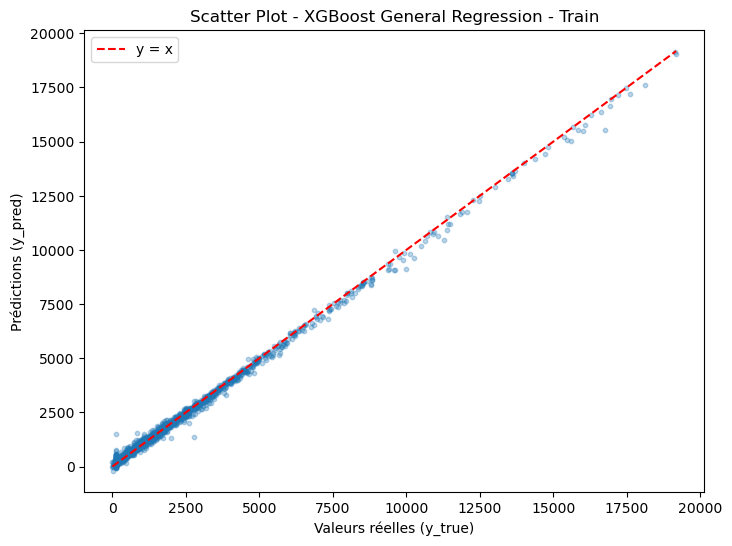

In [437]:
scatter_predictions(couts_train[y_train>0], bst.predict(dtrain), title="Scatter Plot - XGBoost General Regression - Train")

In [433]:
qqplot_plotly2(couts_test[y_test>0], bst.predict(dtest), title="QQ-Plot - XGBoost General Regression - Test")


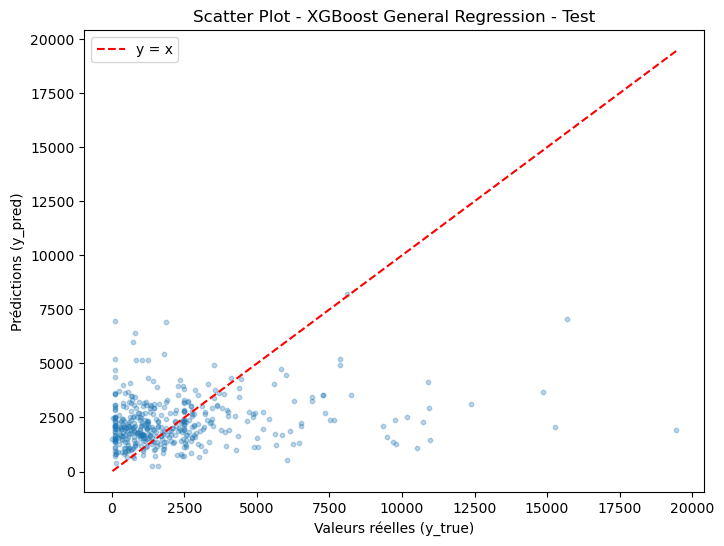

In [425]:
scatter_predictions(couts_test[y_test>0], bst.predict(dtest), title="Scatter Plot - XGBoost General Regression - Test")

In [379]:
from sklearn.linear_model import LinearRegression

pipeline_GammaReg2 = Pipeline([
    ('preprocessor', preprocessor),
    ('model', GammaRegressor(alpha=0.909))
    
])
pipeline_GammaReg2.fit(X_train[y_train>0], couts_train[y_train>0])
y_pred = pipeline_GammaReg2.predict(X_train[y_train>0])
qqplot_plotly2(couts_train[y_train>0], y_pred, title="QQ-Plot - Gamma Regression - Train")

In [ ]:
from sklearn.linear_model import LinearRegression

pipeline_GammaReg2 = Pipeline([
    ('preprocessor', preprocessor),
    # ('model', GammaRegressor(alpha=0.909, ))
    ('model', LinearRegression(n_jobs=-1))
])
pipeline_GammaReg2.fit(X_train[y_train>0], couts_train[y_train>0])
y_pred = pipeline_GammaReg2.predict(X_train[y_train>0])
qqplot_plotly2(couts_train[y_train>0], y_pred, title="QQ-Plot - Gamma Regression - Train")

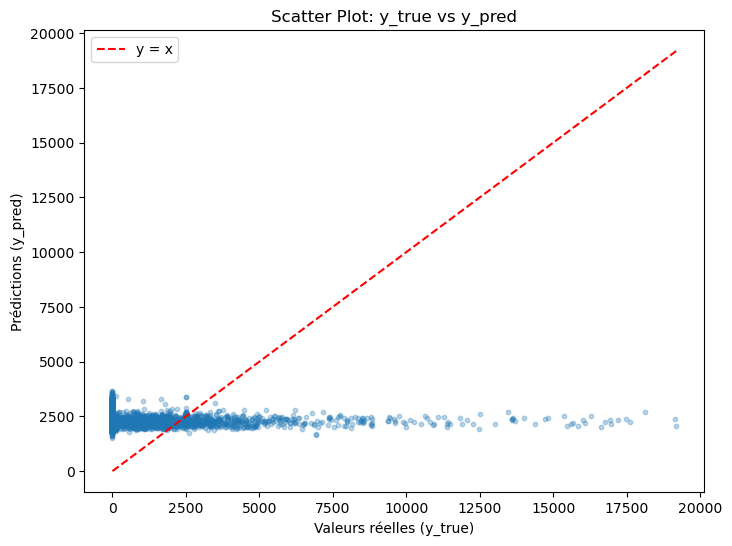

In [288]:
scatter_predictions(
    gamma_y_true,
    gamma_y_pred)

In [286]:
qqplot_plotly2(
    gamma_y_true,
    gamma_y_pred,
    title="QQ-Plot - Gamma Regression - Tous les folds"
)

In [70]:
df_results = pd.concat(results,axis=0)
df_results.head()

NameError: name 'results' is not defined

In [94]:
df_results[['pred_y','pred_c','pred_prime']].describe()

pred_y        pred_c    pred_prime
count  31929.000000  31929.000000  31929.000000
mean       0.054465   2293.230235    124.518384
std        0.226936    193.787194    500.187163
min        0.000000   1501.489498      5.000000
25%        0.000000   2159.491259      5.000000
50%        0.000000   2283.982140      5.000000
75%        0.000000   2413.701735      5.000000
max        1.000000   3673.478220   3271.802027

## Mesures de performances

In [95]:
from sklearn.metrics import root_mean_squared_error, mean_absolute_error, f1_score

<b>Variable proba de sinistres</b>

In [96]:
f1_score(df_results['y'] , df_results['pred_y'])

0.09210142815505684

<b>Variable cout</b>

In [97]:
df_results.loc[df_results.cout>0,'cout'].std()

2766.3707301317136

In [98]:
root_mean_squared_error(df_results.loc[df_results.cout>0,'cout'] , df_results.loc[df_results.cout>0,'pred_c'])

2763.504107257006

In [99]:
mean_absolute_error(df_results.loc[df_results.cout>0,'cout'] , df_results.loc[df_results.cout>0,'pred_c'])

1774.9269528747473

<b>Variable prime</b>

In [100]:
df_results['pred_prime'].std()

500.18716303516857

In [101]:
root_mean_squared_error(df_results['cout'] , df_results['pred_prime'])

949.8103645591395

In [102]:
df_results['cout'].sum()/df_results['pred_prime'].sum()

0.9787278793417434

## Interprétabilité et validation des modèles construits

```
- Zoomer sur l'importance des variables de manière intrinsèque ou agnostique
- Utiliser le package shap pour une approche globale ou locale
```

## Performance par segment
Changez les segments à votre guise pour analyser les résultats ou pour combiner des modèles et ainsi performer la prédiction des primes

In [103]:
segmentation = ['GENRE_ASSURE','ANCIENNETE_PERMIS']

df1 = df_results[segmentation + ['y','pred_y']].groupby(segmentation).apply(lambda x: f1_score(x['y'],x['pred_y'],zero_division=False),include_groups=False).reset_index()
df2 = df_results[segmentation + ['cout','pred_c']].groupby(segmentation).apply(lambda x: root_mean_squared_error(x['cout'],x['pred_c']),include_groups=False).reset_index()
df3 = df_results[segmentation + ['cout','pred_prime']].groupby(segmentation).apply(lambda x: root_mean_squared_error(x['cout'],x['pred_prime']),include_groups=False).reset_index()
df4 = df_results[segmentation + ['cout']].groupby(segmentation).count().reset_index()
df1.columns = segmentation + ['f1_score']
df2.columns = segmentation + ['rmse_c']
df3.columns = segmentation + ['rmse_prime']
df4.columns = segmentation + ['count']
df5 = df1.merge(df2)
df5 = df5.merge(df3)
df5 = df5.merge(df4)  

In [104]:
df5

GENRE_ASSURE ANCIENNETE_PERMIS  f1_score       rmse_c   rmse_prime  count
0             F             (0,1]  0.000000  2183.008876     5.000000      3
1             F             (1,2]  0.000000  2233.653308     5.000000      8
2             F           (12,25]  0.130548  2228.847776   911.149186   2993
3             F             (2,4]  0.000000  2656.431789  2047.650035     44
4             F           (25,60]  0.079188  2264.061684   844.854603   9897
5             F             (4,6]  0.000000  2184.259960   827.689760    102
6             F             (6,8]  0.000000  2226.564669   596.030069    218
7             F            (8,12]  0.118812  2217.769593   923.823390    604
8             M             (0,1]  0.000000  2100.293842     5.000000      1
9             M           (12,25]  0.060403  2371.019751   994.118098   2874
10            M             (2,4]  0.000000  2140.164273  1471.596577     12
11            M           (25,60]  0.093872  2389.078715  1011.090724  14508
12            M             (4,6]  0.222222  2227.872673   877.911846     39
13            M             (6,8]  0.000000  2274.066666   356.778599    164
14            M            (8,12]  0.179104  2412.202784  1194.577986    462

## Prédiction sur la base de test

In [105]:
#Comment prédire sur la base de test ?
pipeline_1 = pipeline_LogReg.fit(X_train,y_train)
pred_1 = pipeline_1.predict(X_test)
pipeline_2 = pipeline_GammaReg.fit(X_train[y_train>0],couts_train[y_train>0])
pred_2 = pipeline_2.predict(X_test)
df_TEST = X_test.copy()
df_TEST['cout'] = couts_test
df_TEST['y'] = couts_test
df_TEST.loc[df_TEST['y'] > 0, 'y'] = 1 
df_TEST['pred_y'] = pred_1
df_TEST['pred_c'] = pred_2
df_TEST['pred_prime'] = [max(5,x) for x in (pred_1 * pred_2)]

In [106]:
df_TEST['cout'].sum()/df_TEST['pred_prime'].sum()

1.0100206713483717

In [107]:
root_mean_squared_error(df_TEST['cout'] , df_TEST['pred_prime'])

900.6124656106161